In [1]:
!pip install pytorch_tabnet
!pip install optuna

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Colab_Notebooks/DS_Project

/content/drive/MyDrive/Colab_Notebooks/DS_Project


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

Seed = 25

# Encoder
# One-hot Encoder
def one_Hot_Encoder(df) :

  ohe = OneHotEncoder()

  # object type의 개수만큼 encoding 진행
  object_cnt = (df.dtypes == 'object').sum()
  for i in range(object_cnt) :
    ohe_label = ohe.fit_transform(df.iloc[:, i].values.reshape(-1, 1)).toarray()
    df_ohe = pd.DataFrame(ohe_label, columns=[df.columns[i] + "_" + str(ohe.categories_[0][j]) for j in range (len(ohe.categories_[0]))])
    df = pd.concat([df, df_ohe], axis=1)

  return df

# Label Encoder
def label_Encoder(arr) :

  le = LabelEncoder()

  # Label encoding
  le.fit(arr)
  arr_encoded = le.transform(arr)

  return arr_encoded

# Data Manipulation
# Dataset 생성하는 메서드
def manipulate(df) :

  # Data Manipulation
  df['fact'] = df['Num'].str[8:10]
  df['code'] = df['Num'].str[10:]
  df['duration'] = (pd.to_datetime(df['buydate']) - pd.to_datetime(df['date'])).dt.days
  df['ingr_A_per'] = df['ingr_A'] / df['gram'] * 100
  df['ingr_B_per'] = df['ingr_B'] / df['gram'] * 100
  df['ingr_C_per'] = df['ingr_C'] / df['gram'] * 100

  # Temp Columns
  dates = df['date']
  wtcds = df['wtcd']
  # Project the needed columns
  columns = ['prod', 'insp', 'duration', 'ingr_A_per', 'ingr_B_per', 'ingr_C_per', 'label'] # 'buydate', 'ingr_A', 'ingr_B', 'ingr_C', 'gram', 'wtcd',
  df = df[columns]

  # One-hot Encoding
  df = one_Hot_Encoder(df)
  # Encoding에 사용된 columns 삭제
  object_cnt = (df.dtypes == 'object').sum()
  df = df.iloc[:, object_cnt:]

  # Label Encoding
  lb_encoded = label_Encoder(wtcds)
  # 반환받은 array를 DataFrame으로 변환
  lb_encoded_df = pd.DataFrame(lb_encoded)
  lb_encoded_df.columns = ['wtcd']
  # 순서(크기) 속성에 맞게 값 교환
  idx0 = lb_encoded_df[lb_encoded_df['wtcd'] == 0].index
  idx1 = lb_encoded_df[lb_encoded_df['wtcd'] == 1].index
  lb_encoded_df.loc[idx0, 'wtcd'] = 1
  lb_encoded_df.loc[idx1, 'wtcd'] = 0
  # 원본 df에 병합
  df = pd.concat([df, lb_encoded_df, dates], axis=1)
  # wtcd 컬럼 속성으로 NaN값 처리 -> drop
  idx = df[df['wtcd'] == 3].index
  df.drop(idx, inplace=True)
  df.reset_index(drop=True, inplace=True)

  # 적절한 threshold 설정 후
  # date를 자체적으로 one-hot encoding
  df['date'] = pd.to_datetime(df['date'])
  df['threshold'] = (df['date'] >= '2023-05-25').astype(int)
  df.drop('date', axis=1,inplace=True)

  return df

# Pretrain을 위한 객체 생성
def pretrainer(study, x_train, x_valid) :

  unsupervised_model = TabNetPretrainer(optimizer_fn=torch.optim.Adam,
                                        optimizer_params=dict(lr=study.best_trial.params['lr']),
                                        mask_type='sparsemax',
                                        n_shared_decoder=1,
                                        n_indep_decoder=1,
                                        verbose=10)

  unsupervised_model.fit(X_train=x_train,
                         eval_set=[x_valid],
                         max_epochs=50,
                         patience=5,
                         batch_size=2048,
                         virtual_batch_size=128,
                         num_workers=0,
                         drop_last=False,
                         pretraining_ratio=0.5,)

  return unsupervised_model

# 목적 함수 => 하이퍼 파라미터 최적화
def objective(trial, seed, x_train, x_valid, y_train, y_valid) :

  # 추적할 하이퍼 파라미터 정의
  lr = trial.suggest_float('lr', 1e-5, 1e-2)
  n_d_a = trial.suggest_int('n_d_a', 8, 64)
  n_steps = trial.suggest_int('n_steps', 3, 10)
  gamma = trial.suggest_float('gamma', 1.0, 2.0)

  # tabnet에서 활용할 params 정의
  # hot_encoding, label encoding했으므로 cat_index X
  tabnet_params = {"optimizer_fn":torch.optim.Adam,
                   "optimizer_params":dict(lr=lr),
                   "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                   "scheduler_params":{"gamma":0.9, "step_size":50},
                   "mask_type":'sparsemax',
                   "device_name":'cuda',
                   "n_d": n_d_a,
                   "n_a": n_d_a,
               	   "n_steps": n_steps,
                   "gamma": gamma,
              	   "seed": Seed}
  clf = TabNetClassifier(**tabnet_params)

  max_epochs = 10

  # Fitting the model
  clf.fit (
      X_train=x_train, y_train=y_train,
      eval_set=[(x_train, y_train), (x_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=['accuracy', 'logloss'],
      max_epochs=max_epochs,
      patience=20,
      batch_size=1024,
      virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False,
  )

  # return minimun loss
  return clf.best_cost


In [5]:
# Load Dataset
df = pd.read_csv("./train.csv")
df = manipulate(df);

# Split the label
labels = df['label']
df = df.drop('label', axis=1)

# train, validate을 위한 데이터 분리
# validate_size = 0.2, Seed 고정
X_train, X_valid, Y_train, Y_valid = train_test_split(df, labels, test_size=0.2, random_state=Seed)
x_train = X_train.values
x_valid = X_valid.values
y_train = Y_train.values
y_valid = Y_valid.values

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07744 | train_accuracy: 0.5809  | train_logloss: 0.7004  | val_accuracy: 0.5961  | val_logloss: 0.68385 |  0:00:01s
epoch 1  | loss: 0.91156 | train_accuracy: 0.55825 | train_logloss: 0.74697 | val_accuracy: 0.56206 | val_logloss: 0.7309  |  0:00:03s
epoch 2  | loss: 0.81576 | train_accuracy: 0.5983  | train_logloss: 0.69824 | val_accuracy: 0.5996  | val_logloss: 0.70948 |  0:00:04s
epoch 3  | loss: 0.73125 | train_accuracy: 0.61407 | train_logloss: 0.67818 | val_accuracy: 0.61361 | val_logloss: 0.67644 |  0:00:06s
epoch 4  | loss: 0.68867 | train_accuracy: 0.63083 | train_logloss: 0.65997 | val_accuracy: 0.64114 | val_logloss: 0.65749 |  0:00:09s
epoch 5  | loss: 0.64185 | train_accuracy: 0.66688 | train_logloss: 0.63626 | val_accuracy: 0.66767 | val_logloss: 0.63569 |  0:00:12s
epoch 6  | loss: 0.62373 | train_accuracy: 0.68715 | train_logloss: 0.61814 | val_accuracy: 0.68168 | val_logloss: 0.61521 |  0:00:14s
epoch 7  | loss: 0.59607 | train_accuracy: 0.73095 | tr

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


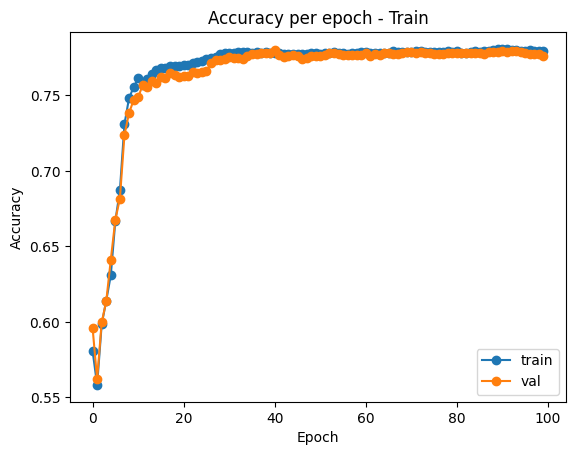

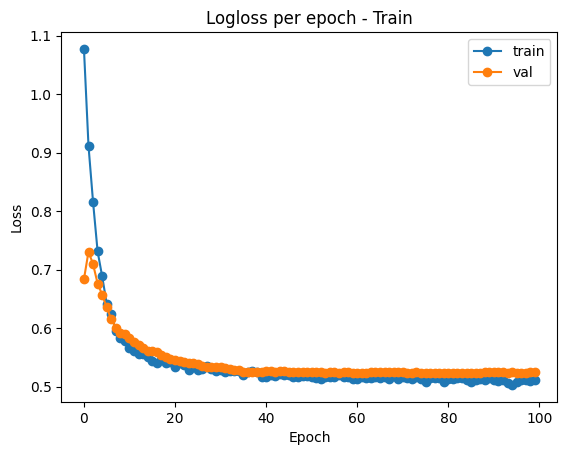

In [6]:
# 단순 딥러닝 학습 모델로 예측

tabnet_params = {"optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=1e-3),
                 "scheduler_fn": torch.optim.lr_scheduler.StepLR,
		             "scheduler_params":{"gamma":0.9, "step_size":50},
                 "mask_type": 'sparsemax',
                 "device_name": 'cuda',
                 "n_d": 8,
                 "n_a": 8,
                 "n_steps": 3,
                 "gamma": 1.3,
                 "seed": Seed}
clf1 = TabNetClassifier(**tabnet_params)

# max_epcohs = #으로 피팅
max_epochs = 100
clf1.fit(X_train=x_train, y_train=y_train,
        eval_set=[(x_train, y_train), (x_valid, y_valid)],
        eval_name=['train', 'val'],
        eval_metric=['accuracy', 'logloss'],
        max_epochs=max_epochs,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,)

# Plot Accuracy
plt.plot(clf1.history['train_accuracy'], label='train', marker='o')
plt.plot(clf1.history['val_accuracy'], label='val', marker='o')
plt.title('Accuracy per epoch - Train')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.plot(clf1.history['loss'], label='train', marker='o')
plt.plot(clf1.history['val_logloss'], label='val', marker='o')
plt.title('Logloss per epoch - Train')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [7]:
# Test set에 대한 Accuracy

from sklearn.metrics import accuracy_score

# Load Dataset
test_df = pd.read_csv("./test_with_labels.csv")
test_df = manipulate(test_df)

# Split the label
test_labels = test_df['label']
test_df = test_df.drop('label', axis=1)

preds = clf1.predict(test_df.values)
test_acc = accuracy_score(y_pred=preds, y_true=test_labels.values)
print(test_acc)

0.7788923354012407


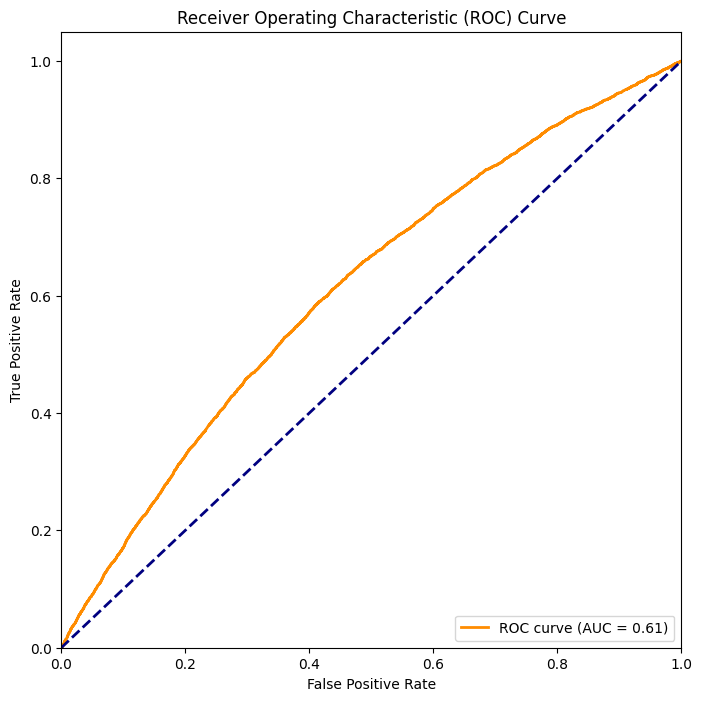

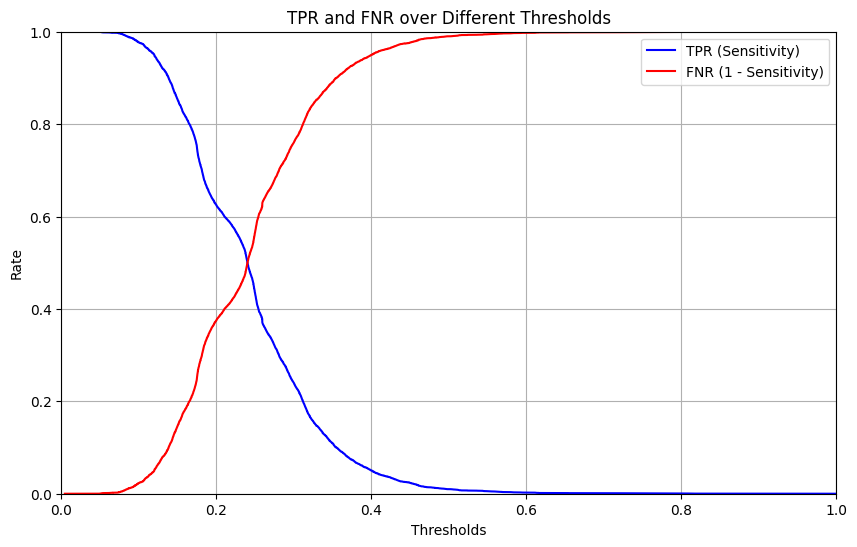

In [8]:
# AUC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_probs = clf1.predict_proba(test_df.values)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# FNR 계산
fnr = 1 - tpr

# TPR과 FNR 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fnr, label='FNR (1 - Sensitivity)', color='red')
plt.title('TPR and FNR over Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.gca().invert_xaxis() # 임계값이 높을수록 TPR과 FNR이 낮아지므로 x축을 반전시킵니다.
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [9]:
# Optuna를 사용하여 하이퍼파라미터 튜닝 수행
trace = optuna.create_study(study_name='TabNet', direction='minimize', sampler=TPESampler(seed=Seed))
trace.optimize(lambda trial: objective(trial, Seed, x_train, x_valid, y_train, y_valid), n_trials=10)
print()
print("Best Score:", trace.best_value)
print("Best trial:", trace.best_trial.params)

# Pretraining
# Pretrainer에게 study 결과 및 데이터셋 전달
unsupervised_model = pretrainer(trace, x_train, x_valid)

[I 2023-12-10 14:25:27,024] A new study created in memory with name: TabNet
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.86998 | train_accuracy: 0.32036 | train_logloss: 1.2032  | valid_accuracy: 0.32032 | valid_logloss: 1.29876 |  0:00:02s
epoch 1  | loss: 0.76198 | train_accuracy: 0.40758 | train_logloss: 0.95956 | valid_accuracy: 0.4024  | valid_logloss: 0.95516 |  0:00:04s
epoch 2  | loss: 0.71808 | train_accuracy: 0.46164 | train_logloss: 0.89505 | valid_accuracy: 0.45896 | valid_logloss: 0.85985 |  0:00:06s
epoch 3  | loss: 0.71323 | train_accuracy: 0.56251 | train_logloss: 0.85236 | valid_accuracy: 0.54805 | valid_logloss: 0.8857  |  0:00:08s
epoch 4  | loss: 0.7165  | train_accuracy: 0.44563 | train_logloss: 0.81651 | valid_accuracy: 0.42993 | valid_logloss: 0.84104 |  0:00:09s
epoch 5  | loss: 0.70248 | train_accuracy: 0.48792 | train_logloss: 0.82527 | valid_accuracy: 0.46146 | valid_logloss: 0.83705 |  0:00:11s
epoch 6  | loss: 0.68836 | train_accuracy: 0.39932 | train_logloss: 0.85802 | valid_accuracy: 0.3979  | valid_logloss: 0.86151 |  0:00:14s
epoch 7  | loss: 0.68746 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:25:49,067] Trial 0 finished with value: 0.7681090847554002 and parameters: {'lr': 0.008702540124905846, 'n_d_a': 41, 'n_steps': 5, 'gamma': 1.1859112320901792}. Best is trial 0 with value: 0.7681090847554002.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05696 | train_accuracy: 0.40408 | train_logloss: 2.09174 | valid_accuracy: 0.41141 | valid_logloss: 2.1423  |  0:00:01s
epoch 1  | loss: 0.9277  | train_accuracy: 0.5077  | train_logloss: 1.17472 | valid_accuracy: 0.50601 | valid_logloss: 1.16509 |  0:00:03s
epoch 2  | loss: 0.84115 | train_accuracy: 0.51658 | train_logloss: 1.00252 | valid_accuracy: 0.53904 | valid_logloss: 0.97583 |  0:00:05s
epoch 3  | loss: 0.79237 | train_accuracy: 0.54749 | train_logloss: 0.84804 | valid_accuracy: 0.55405 | valid_logloss: 0.84625 |  0:00:07s
epoch 4  | loss: 0.76026 | train_accuracy: 0.61244 | train_logloss: 0.74842 | valid_accuracy: 0.60961 | valid_logloss: 0.74151 |  0:00:09s
epoch 5  | loss: 0.73696 | train_accuracy: 0.62032 | train_logloss: 0.69321 | valid_accuracy: 0.5996  | valid_logloss: 0.70809 |  0:00:11s
epoch 6  | loss: 0.7267  | train_accuracy: 0.61006 | train_logloss: 0.69093 | valid_accuracy: 0.58909 | valid_logloss: 0.71689 |  0:00:13s
epoch 7  | loss: 0.7248  | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:26:08,577] Trial 1 finished with value: 0.6786752117461557 and parameters: {'lr': 0.0041168902779718805, 'n_d_a': 14, 'n_steps': 8, 'gamma': 1.4376110596596505}. Best is trial 1 with value: 0.6786752117461557.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01544 | train_accuracy: 0.6003  | train_logloss: 0.74538 | valid_accuracy: 0.58709 | valid_logloss: 0.75152 |  0:00:01s
epoch 1  | loss: 0.77856 | train_accuracy: 0.66637 | train_logloss: 0.71891 | valid_accuracy: 0.67518 | valid_logloss: 0.6905  |  0:00:03s
epoch 2  | loss: 0.72886 | train_accuracy: 0.51032 | train_logloss: 0.88861 | valid_accuracy: 0.51852 | valid_logloss: 0.86117 |  0:00:05s
epoch 3  | loss: 0.70431 | train_accuracy: 0.43061 | train_logloss: 0.83795 | valid_accuracy: 0.41441 | valid_logloss: 0.84417 |  0:00:07s
epoch 4  | loss: 0.68993 | train_accuracy: 0.39244 | train_logloss: 0.90136 | valid_accuracy: 0.38438 | valid_logloss: 0.90992 |  0:00:09s
epoch 5  | loss: 0.69035 | train_accuracy: 0.49618 | train_logloss: 0.76223 | valid_accuracy: 0.48899 | valid_logloss: 0.77616 |  0:00:12s
epoch 6  | loss: 0.69803 | train_accuracy: 0.43236 | train_logloss: 0.7593  | valid_accuracy: 0.41041 | valid_logloss: 0.76813 |  0:00:14s
epoch 7  | loss: 0.68381 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:26:28,178] Trial 2 finished with value: 0.6904974800010972 and parameters: {'lr': 0.005566730958467983, 'n_d_a': 28, 'n_steps': 6, 'gamma': 1.1130407006943963}. Best is trial 1 with value: 0.6786752117461557.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05093 | train_accuracy: 0.5784  | train_logloss: 1.68605 | valid_accuracy: 0.57708 | valid_logloss: 1.6855  |  0:00:01s
epoch 1  | loss: 0.7694  | train_accuracy: 0.67413 | train_logloss: 0.84474 | valid_accuracy: 0.67417 | valid_logloss: 0.84382 |  0:00:03s
epoch 2  | loss: 0.72112 | train_accuracy: 0.64998 | train_logloss: 0.7063  | valid_accuracy: 0.64314 | valid_logloss: 0.73352 |  0:00:05s
epoch 3  | loss: 0.70269 | train_accuracy: 0.47266 | train_logloss: 0.74374 | valid_accuracy: 0.45145 | valid_logloss: 0.75928 |  0:00:08s
epoch 4  | loss: 0.69583 | train_accuracy: 0.54762 | train_logloss: 0.70824 | valid_accuracy: 0.51702 | valid_logloss: 0.72756 |  0:00:10s
epoch 5  | loss: 0.68484 | train_accuracy: 0.57302 | train_logloss: 0.69607 | valid_accuracy: 0.55105 | valid_logloss: 0.71305 |  0:00:11s
epoch 6  | loss: 0.68132 | train_accuracy: 0.53485 | train_logloss: 0.73389 | valid_accuracy: 0.4995  | valid_logloss: 0.75534 |  0:00:13s
epoch 7  | loss: 0.68623 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:26:46,927] Trial 3 finished with value: 0.7130483185465324 and parameters: {'lr': 0.004475838154212219, 'n_d_a': 41, 'n_steps': 4, 'gamma': 1.5207187880526836}. Best is trial 1 with value: 0.6786752117461557.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97506 | train_accuracy: 0.53235 | train_logloss: 1.3775  | valid_accuracy: 0.54304 | valid_logloss: 1.39006 |  0:00:02s
epoch 1  | loss: 0.76318 | train_accuracy: 0.47428 | train_logloss: 0.83289 | valid_accuracy: 0.45445 | valid_logloss: 0.83362 |  0:00:05s
epoch 2  | loss: 0.74265 | train_accuracy: 0.65949 | train_logloss: 0.66096 | valid_accuracy: 0.66617 | valid_logloss: 0.65919 |  0:00:08s
epoch 3  | loss: 0.72756 | train_accuracy: 0.73933 | train_logloss: 0.66045 | valid_accuracy: 0.73323 | valid_logloss: 0.64691 |  0:00:10s
epoch 4  | loss: 0.72236 | train_accuracy: 0.71631 | train_logloss: 0.67669 | valid_accuracy: 0.70721 | valid_logloss: 0.67126 |  0:00:13s
epoch 5  | loss: 0.6976  | train_accuracy: 0.67476 | train_logloss: 0.67148 | valid_accuracy: 0.68018 | valid_logloss: 0.667   |  0:00:15s
epoch 6  | loss: 0.69163 | train_accuracy: 0.63008 | train_logloss: 0.68737 | valid_accuracy: 0.65215 | valid_logloss: 0.67777 |  0:00:18s
epoch 7  | loss: 0.71271 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:27:14,499] Trial 4 finished with value: 0.6469067345519891 and parameters: {'lr': 0.003267250750116877, 'n_d_a': 47, 'n_steps': 5, 'gamma': 1.8363745082660552}. Best is trial 4 with value: 0.6469067345519891.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95924 | train_accuracy: 0.58578 | train_logloss: 2.29698 | valid_accuracy: 0.59259 | valid_logloss: 2.26146 |  0:00:02s
epoch 1  | loss: 0.79569 | train_accuracy: 0.38155 | train_logloss: 1.88258 | valid_accuracy: 0.37538 | valid_logloss: 1.90398 |  0:00:04s
epoch 2  | loss: 0.75896 | train_accuracy: 0.36716 | train_logloss: 2.07423 | valid_accuracy: 0.33834 | valid_logloss: 2.23747 |  0:00:06s
epoch 3  | loss: 0.74006 | train_accuracy: 0.32837 | train_logloss: 1.98185 | valid_accuracy: 0.31181 | valid_logloss: 2.16417 |  0:00:09s
epoch 4  | loss: 0.738   | train_accuracy: 0.29108 | train_logloss: 1.35349 | valid_accuracy: 0.29129 | valid_logloss: 1.40525 |  0:00:12s
epoch 5  | loss: 0.73692 | train_accuracy: 0.34827 | train_logloss: 1.1692  | valid_accuracy: 0.34535 | valid_logloss: 1.18063 |  0:00:15s
epoch 6  | loss: 0.71228 | train_accuracy: 0.25704 | train_logloss: 1.14686 | valid_accuracy: 0.25475 | valid_logloss: 1.14185 |  0:00:18s
epoch 7  | loss: 0.75026 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:27:42,792] Trial 5 finished with value: 0.7283054472827414 and parameters: {'lr': 0.004818616003042698, 'n_d_a': 37, 'n_steps': 6, 'gamma': 1.9975408958775809}. Best is trial 4 with value: 0.6469067345519891.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85877 | train_accuracy: 0.30622 | train_logloss: 7.56438 | valid_accuracy: 0.30681 | valid_logloss: 7.40752 |  0:00:02s
epoch 1  | loss: 0.72085 | train_accuracy: 0.32086 | train_logloss: 5.24922 | valid_accuracy: 0.3043  | valid_logloss: 5.05515 |  0:00:04s
epoch 2  | loss: 0.69331 | train_accuracy: 0.30772 | train_logloss: 4.69932 | valid_accuracy: 0.31031 | valid_logloss: 4.50868 |  0:00:05s
epoch 3  | loss: 0.69782 | train_accuracy: 0.30972 | train_logloss: 3.80425 | valid_accuracy: 0.3043  | valid_logloss: 3.56193 |  0:00:07s
epoch 4  | loss: 0.6958  | train_accuracy: 0.29083 | train_logloss: 3.70191 | valid_accuracy: 0.28228 | valid_logloss: 3.45634 |  0:00:09s
epoch 5  | loss: 0.67868 | train_accuracy: 0.37667 | train_logloss: 2.00195 | valid_accuracy: 0.36386 | valid_logloss: 1.92184 |  0:00:10s
epoch 6  | loss: 0.67637 | train_accuracy: 0.39006 | train_logloss: 2.26535 | valid_accuracy: 0.38138 | valid_logloss: 2.17859 |  0:00:12s
epoch 7  | loss: 0.6776  | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:28:01,205] Trial 6 finished with value: 1.427331212228699 and parameters: {'lr': 0.005147302437635271, 'n_d_a': 39, 'n_steps': 3, 'gamma': 1.7199300263673347}. Best is trial 4 with value: 0.6469067345519891.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11247 | train_accuracy: 0.38043 | train_logloss: 1.65796 | valid_accuracy: 0.39089 | valid_logloss: 1.64309 |  0:00:02s
epoch 1  | loss: 0.89082 | train_accuracy: 0.46753 | train_logloss: 1.22951 | valid_accuracy: 0.46997 | valid_logloss: 1.2191  |  0:00:04s
epoch 2  | loss: 0.80218 | train_accuracy: 0.65298 | train_logloss: 0.73766 | valid_accuracy: 0.66567 | valid_logloss: 0.70926 |  0:00:06s
epoch 3  | loss: 0.76411 | train_accuracy: 0.56826 | train_logloss: 0.79421 | valid_accuracy: 0.57808 | valid_logloss: 0.81374 |  0:00:08s
epoch 4  | loss: 0.75323 | train_accuracy: 0.64197 | train_logloss: 0.68703 | valid_accuracy: 0.63263 | valid_logloss: 0.69659 |  0:00:09s
epoch 5  | loss: 0.72312 | train_accuracy: 0.67426 | train_logloss: 0.63847 | valid_accuracy: 0.66667 | valid_logloss: 0.64044 |  0:00:11s
epoch 6  | loss: 0.71842 | train_accuracy: 0.71731 | train_logloss: 0.61835 | valid_accuracy: 0.71622 | valid_logloss: 0.62032 |  0:00:13s
epoch 7  | loss: 0.72038 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:28:22,194] Trial 7 finished with value: 0.6203214984146991 and parameters: {'lr': 0.0042158254405963505, 'n_d_a': 32, 'n_steps': 5, 'gamma': 1.9002743380567129}. Best is trial 7 with value: 0.6203214984146991.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85012 | train_accuracy: 0.39357 | train_logloss: 1.3682  | valid_accuracy: 0.38839 | valid_logloss: 1.3708  |  0:00:01s
epoch 1  | loss: 0.74111 | train_accuracy: 0.49731 | train_logloss: 0.96344 | valid_accuracy: 0.47798 | valid_logloss: 0.97422 |  0:00:03s
epoch 2  | loss: 0.71725 | train_accuracy: 0.47791 | train_logloss: 0.80644 | valid_accuracy: 0.46246 | valid_logloss: 0.81927 |  0:00:04s
epoch 3  | loss: 0.71525 | train_accuracy: 0.35377 | train_logloss: 0.9042  | valid_accuracy: 0.33033 | valid_logloss: 0.91937 |  0:00:06s
epoch 4  | loss: 0.70593 | train_accuracy: 0.30947 | train_logloss: 1.00754 | valid_accuracy: 0.3018  | valid_logloss: 1.00615 |  0:00:08s
epoch 5  | loss: 0.68925 | train_accuracy: 0.48855 | train_logloss: 0.82324 | valid_accuracy: 0.45095 | valid_logloss: 0.86398 |  0:00:10s
epoch 6  | loss: 0.68838 | train_accuracy: 0.51671 | train_logloss: 0.80557 | valid_accuracy: 0.49249 | valid_logloss: 0.84368 |  0:00:12s
epoch 7  | loss: 0.6825  | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:28:41,539] Trial 8 finished with value: 0.7391185947128779 and parameters: {'lr': 0.006699426658290948, 'n_d_a': 33, 'n_steps': 5, 'gamma': 1.525818963464722}. Best is trial 7 with value: 0.6203214984146991.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42609 | train_accuracy: 0.46778 | train_logloss: 1.84723 | valid_accuracy: 0.46547 | valid_logloss: 1.93123 |  0:00:03s
epoch 1  | loss: 0.99048 | train_accuracy: 0.49018 | train_logloss: 1.71302 | valid_accuracy: 0.50751 | valid_logloss: 1.61884 |  0:00:08s
epoch 2  | loss: 0.98186 | train_accuracy: 0.26492 | train_logloss: 1.81406 | valid_accuracy: 0.26827 | valid_logloss: 1.81871 |  0:00:14s
epoch 3  | loss: 0.90969 | train_accuracy: 0.46577 | train_logloss: 0.99533 | valid_accuracy: 0.47047 | valid_logloss: 0.98634 |  0:00:18s
epoch 4  | loss: 0.91767 | train_accuracy: 0.50544 | train_logloss: 0.89499 | valid_accuracy: 0.504   | valid_logloss: 0.87826 |  0:00:22s
epoch 5  | loss: 0.86863 | train_accuracy: 0.40383 | train_logloss: 1.36947 | valid_accuracy: 0.4009  | valid_logloss: 1.40683 |  0:00:26s
epoch 6  | loss: 0.90864 | train_accuracy: 0.5311  | train_logloss: 1.24298 | valid_accuracy: 0.51251 | valid_logloss: 1.28831 |  0:00:32s
epoch 7  | loss: 0.86812 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-12-10 14:29:28,374] Trial 9 finished with value: 0.8782593240735933 and parameters: {'lr': 0.005596828194400601, 'n_d_a': 50, 'n_steps': 9, 'gamma': 1.823694451925049}. Best is trial 7 with value: 0.6203214984146991.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")



Best Score: 0.6203214984146991
Best trial: {'lr': 0.0042158254405963505, 'n_d_a': 32, 'n_steps': 5, 'gamma': 1.9002743380567129}
epoch 0  | loss: 19.7722 | val_0_unsup_loss_numpy: 169.50633239746094|  0:00:00s
epoch 10 | loss: 2.33697 | val_0_unsup_loss_numpy: 2.2049601078033447|  0:00:05s
epoch 20 | loss: 1.35397 | val_0_unsup_loss_numpy: 1.388159990310669|  0:00:10s
epoch 30 | loss: 1.2524  | val_0_unsup_loss_numpy: 1.3069299459457397|  0:00:17s
epoch 40 | loss: 1.21858 | val_0_unsup_loss_numpy: 1.2713299989700317|  0:00:22s
Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_unsup_loss_numpy = 1.2343000173568726


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: n_a changed from 32 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: n_d changed from 32 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1.12359 | train_accuracy: 0.35878 | train_logloss: 0.83563 | val_accuracy: 0.36036 | val_logloss: 0.8319  |  0:00:01s
epoch 1  | loss: 0.66252 | train_accuracy: 0.72394 | train_logloss: 0.62989 | val_accuracy: 0.71121 | val_logloss: 0.64109 |  0:00:02s
epoch 2  | loss: 0.5594  | train_accuracy: 0.76386 | train_logloss: 0.57366 | val_accuracy: 0.76076 | val_logloss: 0.57183 |  0:00:04s
epoch 3  | loss: 0.55245 | train_accuracy: 0.77437 | train_logloss: 0.56858 | val_accuracy: 0.77377 | val_logloss: 0.56306 |  0:00:05s
epoch 4  | loss: 0.5375  | train_accuracy: 0.77562 | train_logloss: 0.56145 | val_accuracy: 0.76977 | val_logloss: 0.56202 |  0:00:07s
epoch 5  | loss: 0.53092 | train_accuracy: 0.77662 | train_logloss: 0.5515  | val_accuracy: 0.77227 | val_logloss: 0.55151 |  0:00:10s
epoch 6  | loss: 0.5276  | train_accuracy: 0.77775 | train_logloss: 0.54576 | val_accuracy: 0.77327 | val_logloss: 0.54591 |  0:00:12s
epoch 7  | loss: 0.52776 | train_accuracy: 0.77775 | tr

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


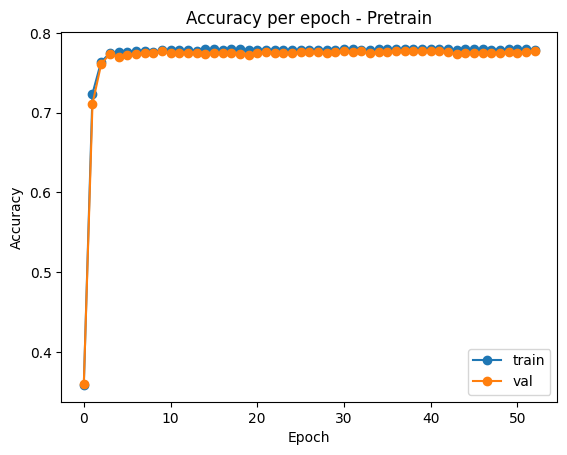

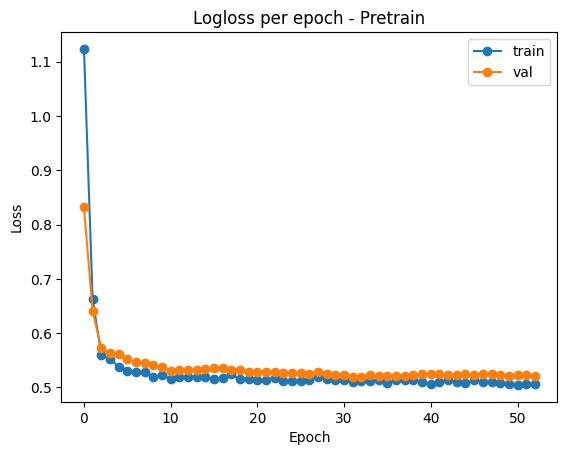

In [11]:
# 하이퍼파라미터 및 Pretrain된 모델을 활용해서 학습

tabnet_params = {"optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=trace.best_trial.params['lr']),
                 "scheduler_fn": torch.optim.lr_scheduler.StepLR,
		             "scheduler_params":{"gamma":0.9, "step_size":50},
                 "mask_type": 'sparsemax',
                 "device_name": 'cuda',
                 "n_d":trace.best_trial.params['n_d_a'],
                 "n_a": trace.best_trial.params['n_d_a'],
                 "n_steps": trace.best_trial.params['n_steps'],
                 "gamma": trace.best_trial.params['gamma'],
                 "seed": Seed}
clf2 = TabNetClassifier(**tabnet_params)

# max_epcohs = #으로 피팅
max_epochs = 100
clf2.fit(X_train=x_train, y_train=y_train,
        eval_set=[(x_train, y_train), (x_valid, y_valid)],
        eval_name=['train', 'val'],
        eval_metric=['accuracy', 'logloss'],
        max_epochs=max_epochs,
        patience=20,
        batch_size=1024,
        virtual_batch_size=128,
        from_unsupervised=unsupervised_model)

# Plot Accuracy
plt.plot(clf2.history['train_accuracy'], label='train', marker='o')
plt.plot(clf2.history['val_accuracy'], label='val', marker='o')
plt.title('Accuracy per epoch - Pretrain')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot loss
plt.plot(clf2.history['loss'], label='train', marker='o')
plt.plot(clf2.history['val_logloss'], label='val', marker='o')
plt.title('Logloss per epoch - Pretrain')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
# Test set에 대한 Accuracy

preds = clf2.predict(test_df.values)
test_acc = accuracy_score(y_pred=preds, y_true=test_labels.values)
print(test_acc)

0.780518310986592


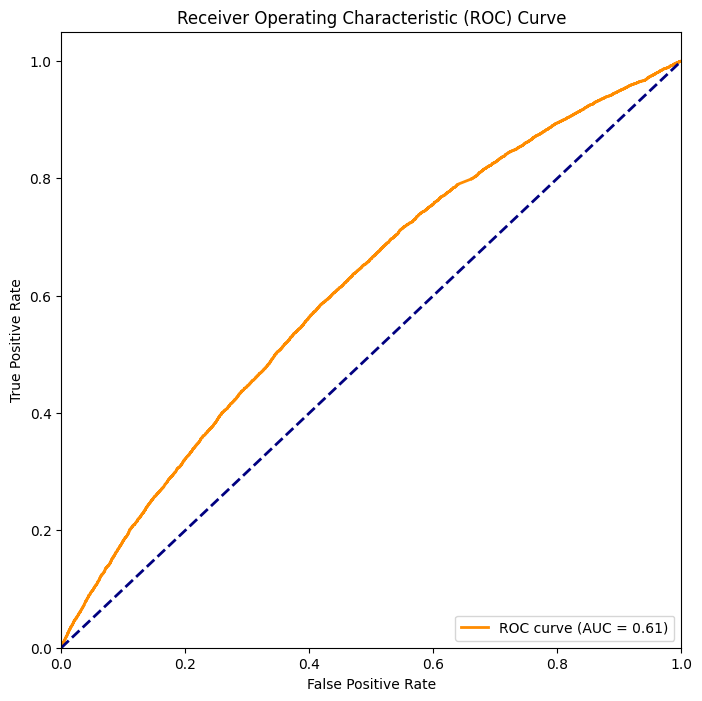

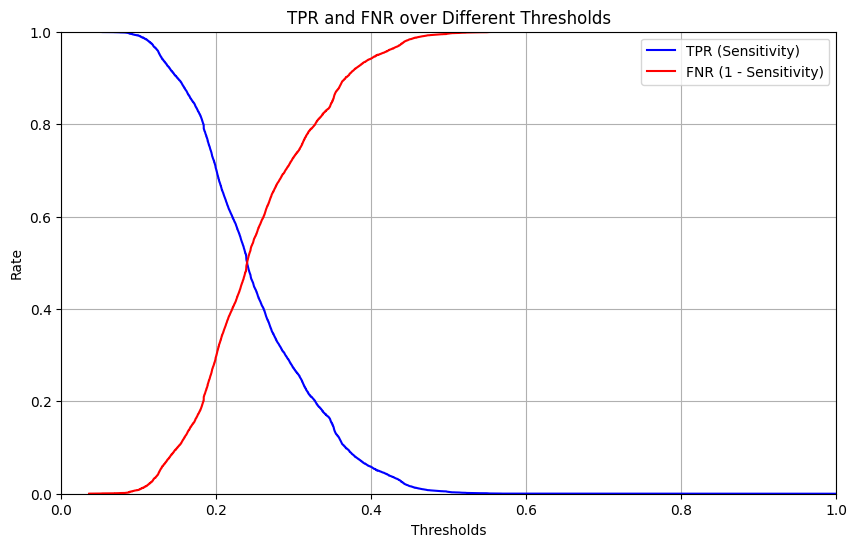

In [15]:
# AUC Curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_probs = clf2.predict_proba(test_df.values)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# FNR 계산
fnr = 1 - tpr

# TPR과 FNR 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fnr, label='FNR (1 - Sensitivity)', color='red')
plt.title('TPR and FNR over Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.gca().invert_xaxis() # 임계값이 높을수록 TPR과 FNR이 낮아지므로 x축을 반전시킵니다.
plt.legend(loc='best')
plt.grid(True)
plt.show()